## Final size for SIR model

Author: Sangeeta Bhatia @sangeetabhatia03

Date: 2018-10-03

This implementation is tested against the MATLAB implementation provided by the authors [here](https://www-sciencedirect-com.iclibezp1.cc.ic.ac.uk/science/article/pii/S0022519314006882#s0035). The following distribution was generated using their code.

In [1]:
## Test data generated using authors' code.
N <- 10
beta <- 2/(N-1);
gamma1 <- 1;
final_size1 <- c(0.00000, 0.33333, 0.08640, 0.04908, 0.03814, 0.03638, 0.04079, 0.05256, 0.07614, 0.11862, 0.16854)

Although most of the code uses base R functions, we load libraries for testing and plotting.

In [2]:
library(ggplot2)
library(testthat)

In [3]:
## Some more test data; extreme cases.
## What if the recovery rate is 0?
gamma2 <- 0
final_size2 <- c(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1)

In [4]:
outbreak_size_distr <- function(N, beta, gamma) {
    ## total number of possible states
    nstates <- (N + 1) * (N + 2) / 2
    ## empty vector to store outbreak size distribution
    distr <- rep(0, N + 1)
    ## probability distribution of states
    p_states <- rep(0, nstates)
    ## Start with 1 infection event. This could be 
    ## customised. Note that state 2 corresponds to
    ## state (1, 0)
    p_states[2] <- 1
    ## counter to index over states
    state <- 1
    for (z2 in 0:N) {
        distr[z2 + 1] <- p_states[state];
        state <- state + 1;
        if ((z2 + 1) > (N - 1)) {
            next
        }        
        for (z1 in (z2 + 1): (N - 1)) {
            p <- 1 / ( 1 + gamma/(beta*(N - z1)))
            p_states[state + 1] <- p_states[state + 1] + p_states[state] * p
            p_states[state + N - z2] <- p_states[state + N - z2] + p_states[state] * (1 - p)
            state <- state + 1
        }
        if (z2 < N) {
            p_states[state + N - z2] <- p_states[state + N - z2] + p_states[state] 
            state <- state + 1         
        }

    }
    distr
}

In [5]:
distr <- outbreak_size_distr(N = 10, beta = 2/9, gamma = 1)
distr <- round(distr, 5)

In [6]:
testthat::expect_equal(distr, final_size1)

In [7]:
distr <- outbreak_size_distr(N = 10, beta = 2/9, gamma = 0)
distr <- round(distr, 5)

In [8]:
testthat::expect_equal(distr, final_size2)

The above assertion checks that everything works as expected. For a given value of N and gamma, how does beta influence the outbreak size distribution?

In [9]:
N <- 100
beta <- seq(from = 10, to = 100, by = 50) / (N - 1)
gamma <- 1
final_distr <- lapply(beta, function(b) outbreak_size_distr(N, beta = b, gamma))

In [10]:
results <- data.frame()
for (i in seq_along(beta)) {
    results <- rbind(results, data.frame(infection_rate = rep(beta[i], N + 1), 
                                         distr = final_distr[[i]]))
}
results$infection_rate <- factor(results$infection_rate)

Thus the probability of the final size of the outbreak being very small or very large is high and close to 0 for anything in between. 
What if we change the recovery rate?

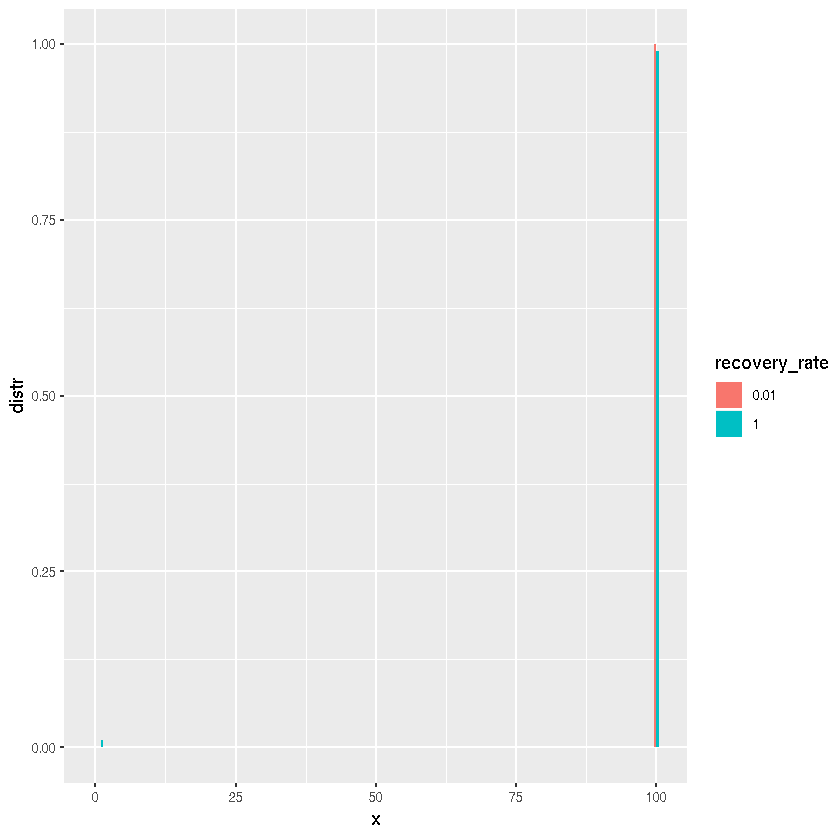

In [11]:
N <- 100
beta <- 99 / (N - 1)
gamma <- beta / c(1, 100)
final_distr <- lapply(gamma, function(g) outbreak_size_distr(N, beta, gamma = g))
results <- data.frame()
for (i in seq_along(gamma)) {
    results <- rbind(results, data.frame(recovery_rate = rep(gamma[i], N + 1), 
                                         distr = final_distr[[i]]))
}
results$recovery_rate <- factor(results$recovery_rate)
x <- rep(0:N, length(gamma))
ggplot(results, aes(x, distr, fill = recovery_rate)) +
  geom_col(position = "dodge")                   